# Continuous phase-type distribution of branch length two pop two loci

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (dfc78fe3) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# %%R
# pkgbuild::check_build_tools(debug = TRUE)

In [4]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial"))

In [5]:
# p <- ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species)) + despine

# ggplotly(width=600, height=400)

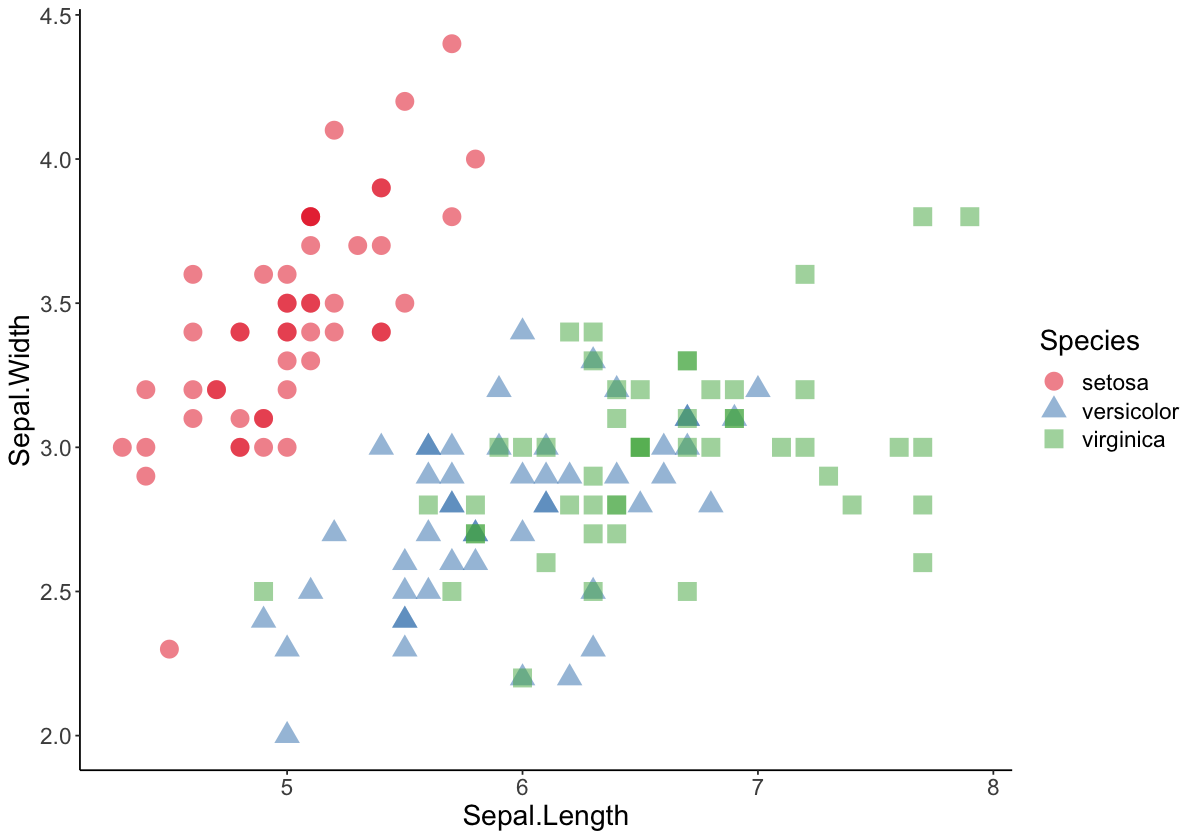

In [6]:
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17)) 

options(repr.plot.width=10, repr.plot.height=7)

ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
      geom_point(aes(color=Species, shape=Species), size=5, alpha=0.5) + scale_color_brewer(palette="Set1") + despine

# Utility functions

In [7]:
# plot_sfs <- function(graph, rewards) {
#     sfs <- sapply(1:(dim(rewards)[1]-1), function(i) expectation(graph, rewards[i,]))
#     data.frame(
#       ton=seq(1,length(sfs)),  
#       brlen=sfs
#       ) %>% ggplot(aes(x=ton, y=brlen, fill=ton)) + 
#       geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + 
#       despine
# }

# plot_sfs_dph <- function(graph, rewards, trunc=4) {
#     result = data.frame()
#     for (i in 1:(nrow(rewards)-1)) {
#         x <- seq(from = 0, to = trunc, by = 0.01)
#         pdf <- dph(x, reward_transform(graph, rewards[i, ]))
#         df <- data.frame(prob = pdf, t=x, ton=i)
#         result <- rbind(result, df)
#     }
#     result %>% ggplot(aes(y=prob, x=t, group=ton, color=ton)) +
#         geom_line(linewidth=1) + scale_color_viridis() + despine
# }

get_exp_mat <- function(graph, rewards, s) {
    exp_mat <- matrix(nrow=s+1,ncol=s+1)
    for (i in 0:s) {
      for (j in 0:s) {
        exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
      }
    } 
    return(exp_mat)
}
                                  
plot_exp_mat <- function(exp_mat) {  
    df <- as.data.frame(exp_mat) #%>% gather()
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))

    limit <- max(abs(df$value)) * c(-1, 1)
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        geom_text(aes(label = round(value, 2))) +
    scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                        limit=limit) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

}

get_cov_mat <- function(graph, rewards) {
    n <- nrow(rewards)
    cov_mat <- matrix(nrow=n-1,ncol=n-1)
    for (i in 1:(n-1)) {
        for (j in 1:(n-1)) {
            cov_mat[i, j] <- covariance(graph, rewards[i,], rewards[j,])
        }
    }
    return(cov_mat)
}
                  
plot_cov_mat <- function(cov_mat) {
   
    df <- as.data.frame(cov_mat)
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        scale_y_discrete(labels= seq(1, nrow(cov_mat))) + 
        scale_fill_continuous(type = "viridis") + 
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

}

plot_graph <- function(gam, constrained=TRUE, size=c(6, 6), fontsize=10, rankdir="LR") {

    if (constrained) {
        constrained <- 'true'
    } else {
        constrained <- 'false'
    }

    edge_templ <- '"FROM" -> "TO" [constraint=true, label="LABEL",labelfloat=false];'
    start_name <- 'IPV'
    absorbing_name <- 'Absorb'
    edges <- c()
    for (i in 1:length(gam$IPV)) {
        if (gam$IPV[i] > 0) {
            edge <- edge_templ
            edge <- sub('FROM', start_name, edge)
            edge <- sub('TO', paste(gam$states[i,], collapse = ","), edge)
            edge <- sub('LABEL', gam$SIM[i, 1], edge)
            edges <- c(edges, edge)
        }
    }    
    for (i in 1:nrow(gam$states)) {
        for (j in 1:nrow(gam$states)) {
            if ((i != j) && (gam$SIM[i, j] > 0)) {
                edge <- edge_templ
                edge <- sub('FROM', paste(gam$states[i,], collapse = ","), edge)
                edge <- sub('TO', paste(gam$states[j,], collapse = ","), edge)
                edge <- sub('LABEL', gam$SIM[i, j], edge)
                edges <- c(edges, edge)
            }
        }
    }
    absorb_rates <- -rowSums(gam$SIM)
    for (i in 1:nrow(gam$states)) {
        if (absorb_rates[i] > 0) {
            # edges <- c(edges, paste('"', from, '"', ' -> ', 'Absorb', '[constraint=true, label="', label, '",labelfloat=false]', ';', sep='')) 
            edge <- edge_templ
            edge <- sub('FROM', paste(gam$states[i,], collapse = ","), edge)
            edge <- sub('TO', absorbing_name, edge)
            edge <- sub('LABEL', absorb_rates[i], edge)
            edges <- c(edges, edge)
        }
    }
    graph_spec <- paste(edges, sep='\n', collapse = '')
    style_str <- '
        rankdir=RANKDIR;
        size="SIZEX,SIZEY";
        fontname="Helvetica,Arial,sans-serif"
    	node [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE]
    	edge [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE]
        Absorb [style=filled,color="lightgrey"]
        IPV [style=filled,color="lightgrey"]
    '
    style_str <- sub('SIZEX', size[1], style_str)
    style_str <- sub('SIZEY', size[2], style_str)
    style_str <- gsub('FONTSIZE', fontsize, style_str)    
    style_str <- gsub('RANKDIR', rankdir, style_str)    
    graph_string <- paste('digraph G {', style_str, graph_spec, '}', sep='\n')
    system("dot -Tsvg -o tmp.svg", input=graph_string, intern=TRUE)
    return(display_svg(file="tmp.svg"))
    }

# State space

## State space in R

In [8]:
# r_construct_twolocus_island_graph <- function(s, N, M, R) {

#     # number of populations
#     p <- 2 # needs to be 2
#     # state vector length
#     n <- p*(s+1)**2

#     graph <- create_graph(n)
#     index <- 1
#     # first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
#     state <- rep(0, n)
#     state[conf_to_index(s, 1, 1, 1)] <- s
#     first_vertex <- create_vertex(graph, state) # assumes that p=2
#     add_edge(starting_vertex(graph), first_vertex, 1)

#     index <- 2
#     while (index <= vertices_length(graph)) {

#       vertex <- vertex_at(graph, index)
#       state <- vertex$state

#       count <- 0
#       for (i in 1:n) {
#           count <- count + state[i]
#       }
#       if (count <= 1) {
#           # Only one lineage, stop
#           index <- index + 1
#           next
#       }    

#       for (i in 1:n) {
#         conf_i <- index_to_conf(s, i)

#         # coalescence #########################
#         for (j in i:n) {
#           conf_j <- index_to_conf(s, j)

#           if (conf_i@population != conf_j@population) {
#             # different populations
#             next
#           }
#           if (i == j) {
#             if (state[i] < 2) {
#               next;
#             }
#             rate <- state[i] * (state[i] - 1) / 2 / N
#           } else {
#             if (state[i] < 1 || state[j] < 1) {
#               next;
#             }
#             rate <- state[i] * state[j] / N
#           }

#           child_state <- state

#           # lineages with index i and j coalesce:  
#           child_state[i] <- child_state[i] - 1
#           child_state[j] <- child_state[j] - 1
#           stopifnot(conf_i@locus1+conf_j@locus1 <= s)
#           stopifnot(conf_i@locus2+conf_j@locus2 <= s)

#           # coalescene into lineage with index k
#           k = conf_to_index(s, conf_i@locus1+conf_j@locus1, conf_i@locus2+conf_j@locus2, conf_i@population)
#           child_state[k] <- child_state[k] + 1

#           child_vertex <- find_or_create_vertex(graph, child_state)
#           add_edge(vertex, child_vertex, rate)
#         }

#         # recombination #######################
#         if (state[i] > 0 && conf_i@locus1 > 0 && conf_i@locus2 > 0) {

#           rate <- R
#           child_state <- state

#           # a lineage with index i recombines to produce lineages with index k and l
#           k = conf_to_index(s, conf_i@locus1, 0, conf_i@population)
#           l = conf_to_index(s, 0, conf_i@locus2, conf_i@population)
#           child_state[i] <- child_state[i] - 1
#           child_state[k] <- child_state[k] + 1
#           child_state[l] <- child_state[l] + 1

#           child_vertex <- find_or_create_vertex(graph, child_state)
#           add_edge(vertex, child_vertex, rate)
#         }

#         # migration ###########################
#         if (state[i] > 0) {

#           rate <- M
#           child_state <- state

#           if (conf_i@population == 1) {
#             m = 2
#           } else {
#             m = 1
#           }
#           # 
#           k = conf_to_index(s, conf_i@locus1, conf_i@locus2, m)
#           child_state[i] <- child_state[i] - 1
#           child_state[k] <- child_state[k] + 1

#           child_vertex <- find_or_create_vertex(graph, child_state)
#           add_edge(vertex, child_vertex, rate)
#         }
#       }

#       index <- index + 1

#       if ((index %% 50) == 0) {
#         cat(index, vertices_length(graph), "\n")
#       }

#     }
    
#     return(graph)
# }

# graph <- r_construct_twolocus_island_graph(2, 1, 0, 1)

# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state, simplify = FALSE))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

# graph_as_matrix(graph)

## State space in C

In [9]:
Rcpp::sourceCpp("./two_locus_two_island.cpp")

Zero-probability transistions are ignored, so the state space is reduced when either recombination rate or migration rate are zero.

Each state has the following three properties:
1. nr decendants at locus 1
2. nr decendants at locus 2
3. what population the lineage is currently in

Rccp exports `construct_twolocus_island_graph`, `index_to_props`, and `props_to_index`:

Sample size:

In [10]:
s <- 2

# Sanity checks without migration

## ARG TMRCA without migration

The minimum of two independent exponential random variables (the loci are independent with large recombination rate) with parameters $\lambda$ and $\eta$ is also exponential with parameter $\lambda+\eta$. Also:

$$\mathbb{E}[\min(X_1, X_2) + \max(X_1, X_2)] = \mathbb{E}[X_1 + X_2] = \frac{1}{\lambda} + \frac{1}{\eta}$$

Because 

$$\mathbb{E}[\min(X_1, X_2)] = \frac{1}{\lambda + \eta},$$

we get

$$\mathbb{E}[\min(X_1, X_2)] = \frac{1}{\lambda} + \frac{1}{\eta} - \frac{1}{\lambda + \eta}$$

So for a sample of two, and a coalescence rate of 1, the expected time to coalescence at *both* loci is $1 + 1 - \frac{1}{1+1} = 1.5$. The time for the two loci to coalesce is 1. So the total ARG TMRCA should be 2.5:

In [11]:

graph <- construct_twolocus_island_graph(2, 1, 1, 0, 0, 0)
expectation(graph)

[1] 1

In [12]:
graph <- construct_twolocus_island_graph(2, 1, 1, 0, 0, 10000000)
expectation(graph)

[1] 2.5

__*Note for Tobias*__: `expectation` does not like null-edges:

In [13]:
# graph <- construct_twolocus_island_graph(2, 1, 1, 0, 0, 10000000, keep_null_edges=TRUE)
# expectation(graph)

## Visualize graph

In [14]:
gam <- graph_as_matrix(graph)

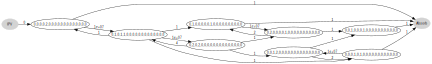

In [15]:
plot_graph(gam)

In [16]:
index_to_props(s, 4)

$locus1
[1] 1

$locus2
[1] 0

$population
[1] 1

## Two-locus SFS without recombination

Expected ARG branches with i and j tons at each locus

In [17]:
s <- 6

graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 0)
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
print(vertices_length(graph))

[1] 12


In [18]:
exp_mat <- matrix(nrow=s+1,ncol=s+1)
for (i in 1:s) {
  for (j in 1:s) {
    exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
  }
}

In [19]:
nrow(rewards)

[1] 98

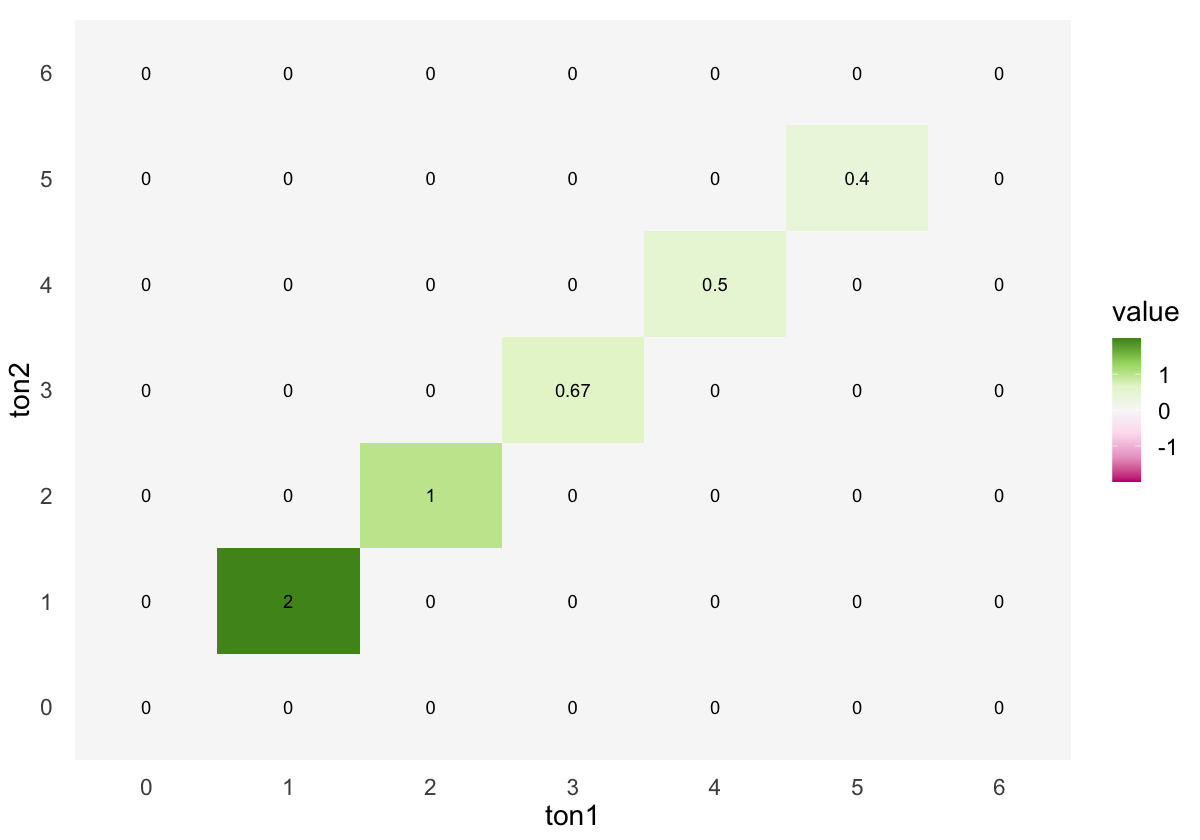

In [20]:
plot_exp_mat(get_exp_mat(graph, rewards, s))

## Two-locus SFS with recombination

Expected ARG branches with i and j tons at each locus

In [21]:
s <- 6

graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 2)
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
print(vertices_length(graph))

[1] 1044


In [22]:
exp_mat <- get_exp_mat(graph, rewards, s)

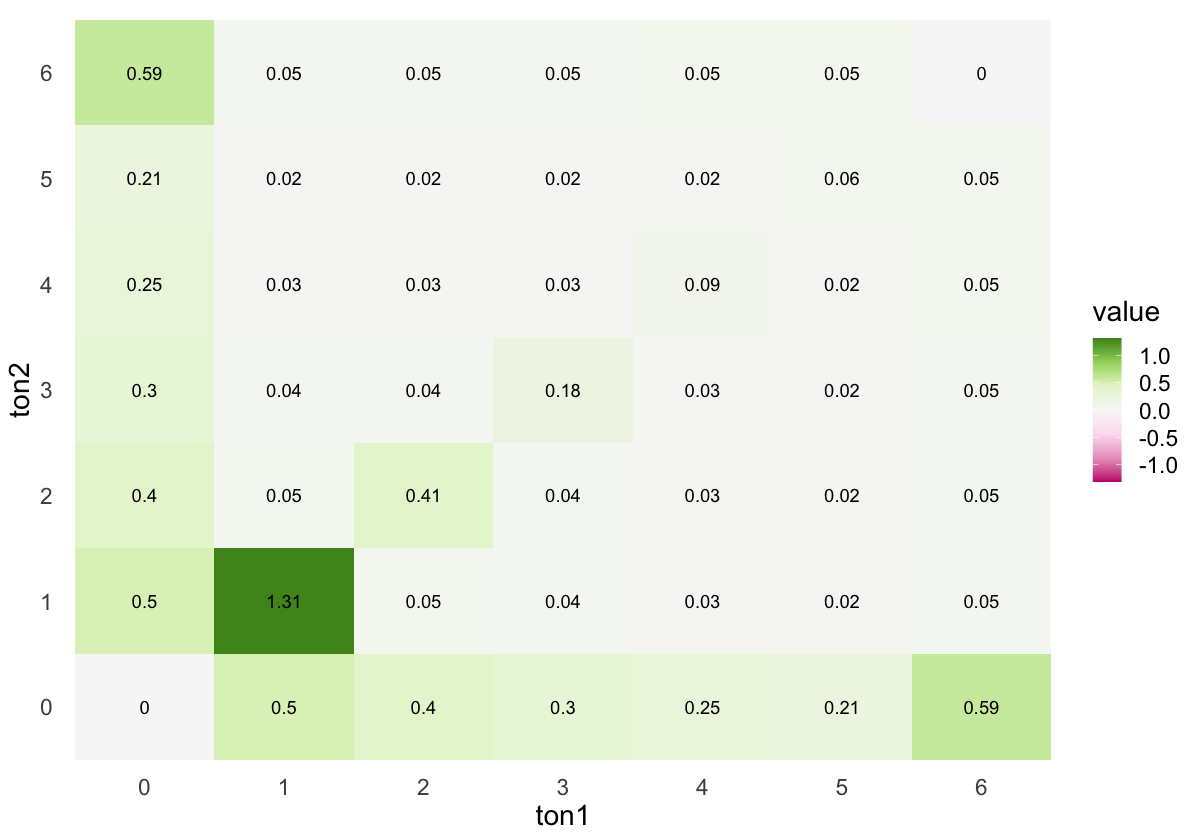

In [23]:
plot_exp_mat(exp_mat)

Marginal SFSs:

In [24]:
x <- colSums(exp_mat)
sfs_locus1 <- x[c(-1, -length(x))]
x <- rowSums(exp_mat)
sfs_locus2 <- x[c(-1, -length(x))]

Fits expectations for a single locus:

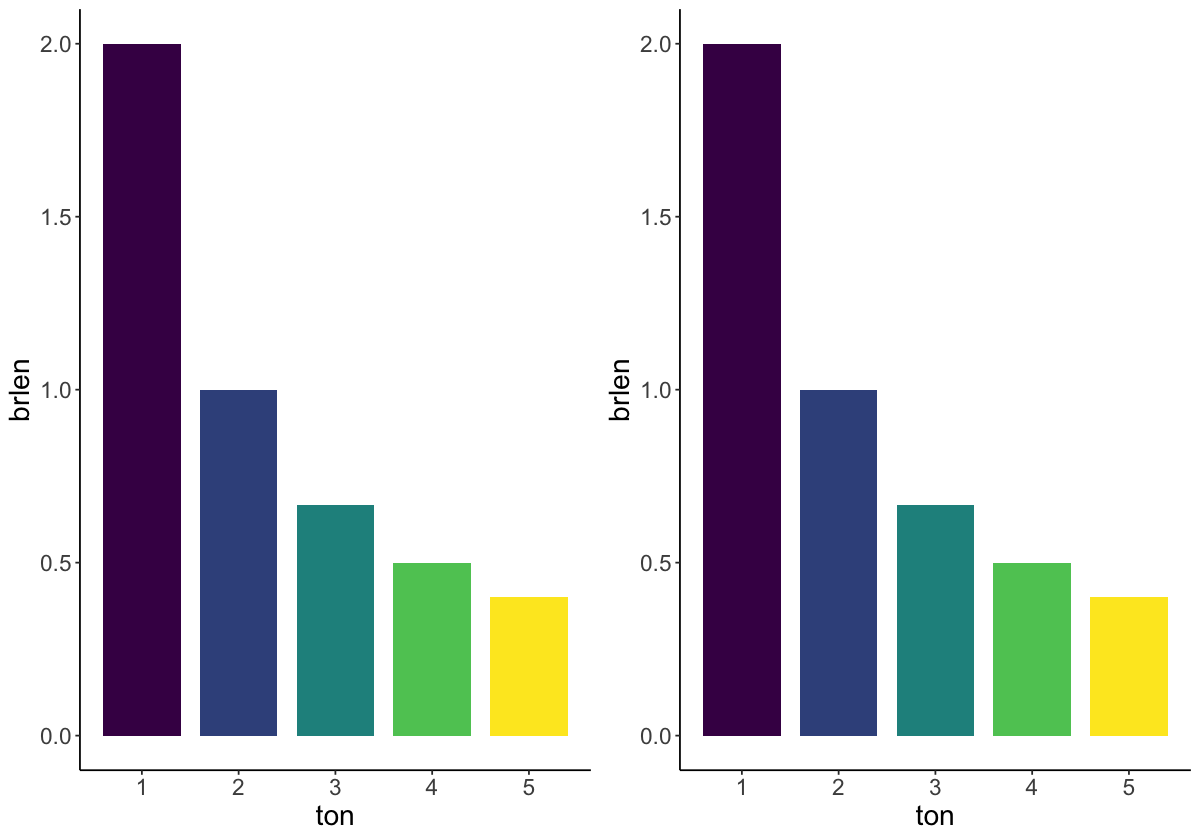

In [25]:
grid.arrange(
    data.frame(
      ton=seq(1,length(sfs_locus1)),  
      brlen=sfs_locus1
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    data.frame(
      ton=seq(1,length(sfs_locus2)),  
      brlen=sfs_locus2
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    nrow = 1)


# PDFs of ARG branch length with i descendants at locus one and two at locus two

In [26]:
result = data.frame()
for (i in 1:(s-1)) {
    for (j in 1:(s-1)) {
        x <- seq(from = 0, to = 5, by = 0.01)
        pdf <- dph(x, reward_transform(graph, rewards[props_to_index(s, i, j, 1),]))

        df <- data.frame(prob = pdf, t=x, i_ton=i, j_ton=j, color=100*j+i)
        result <- rbind(result, df)
    }
}
#result %>% ggplot(aes(y=prob, x=t, color=ton, group=ton)) + geom_line(size=1)

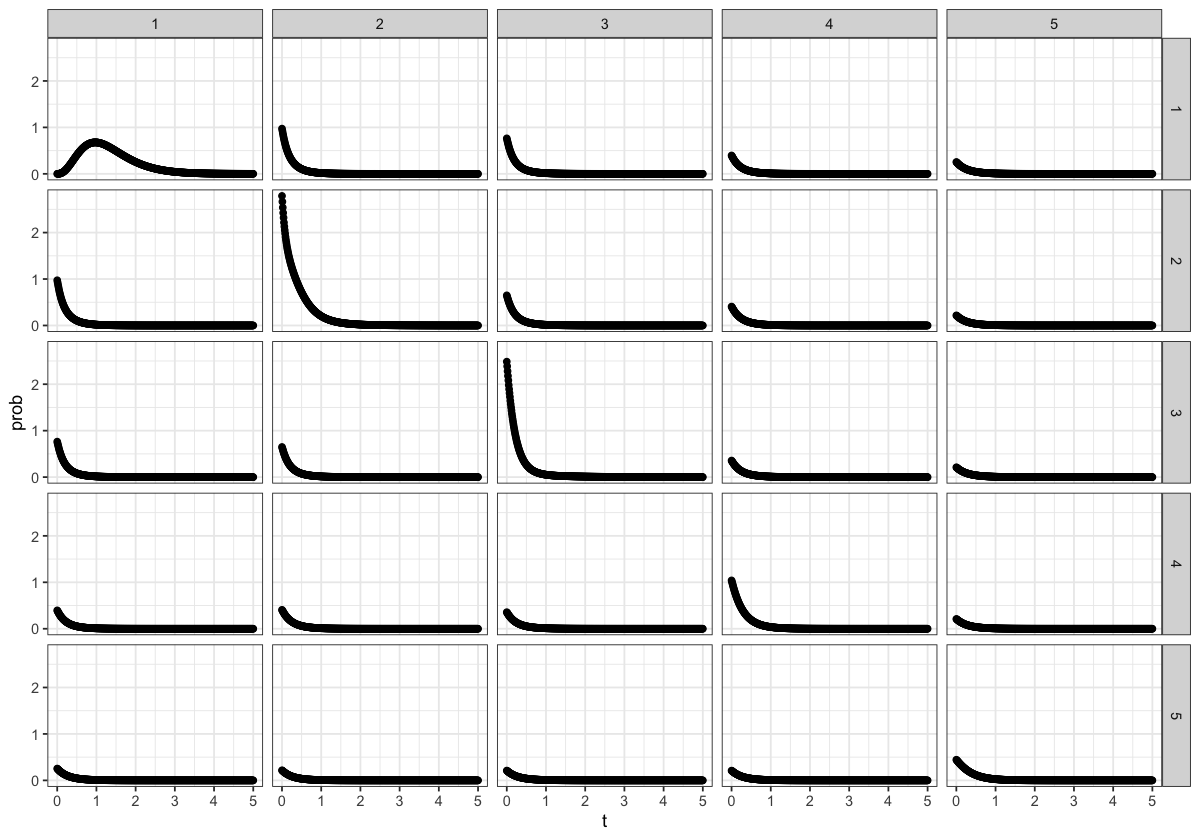

In [27]:
ggplot(result, aes(y=prob, x=t)) + geom_point() +
    facet_grid(i_ton ~ j_ton) +
    theme_bw()

## ARG TMRCA without recombination

Test the classical result that with symmetric migration and sampling from one population, the expectation should be the sum of the two population sizes (2) and independent of the migration rate. The variance is not and should fall with higher migration rate and asymptotically reach (4):

In [28]:
graph <- construct_twolocus_island_graph(2, 1, 1, 10000000000, 10000000000, 0)
variance(graph)

[1] 4

In [29]:
expectation_migrates <- c()
variance_migrates <- c()
mig_rates <- 10^(-5:5)
for (mig_rate in mig_rates) {
    graph <- construct_twolocus_island_graph(2, 1, 1, mig_rate, mig_rate, 0)
    expectation_migrates <- c(expectation_migrates, expectation(graph))
    variance_migrates <- c(variance_migrates, variance(graph))   
}

In [30]:
data.frame(mig_rates=mig_rates, expectation_migrates=expectation_migrates)

mig_rates,expectation_migrates
<dbl>,<dbl>
1e-05,2
1e-04,2
1e-03,2
1e-02,2
1e-01,2
1e+00,2
1e+01,2
1e+02,2
1e+03,2


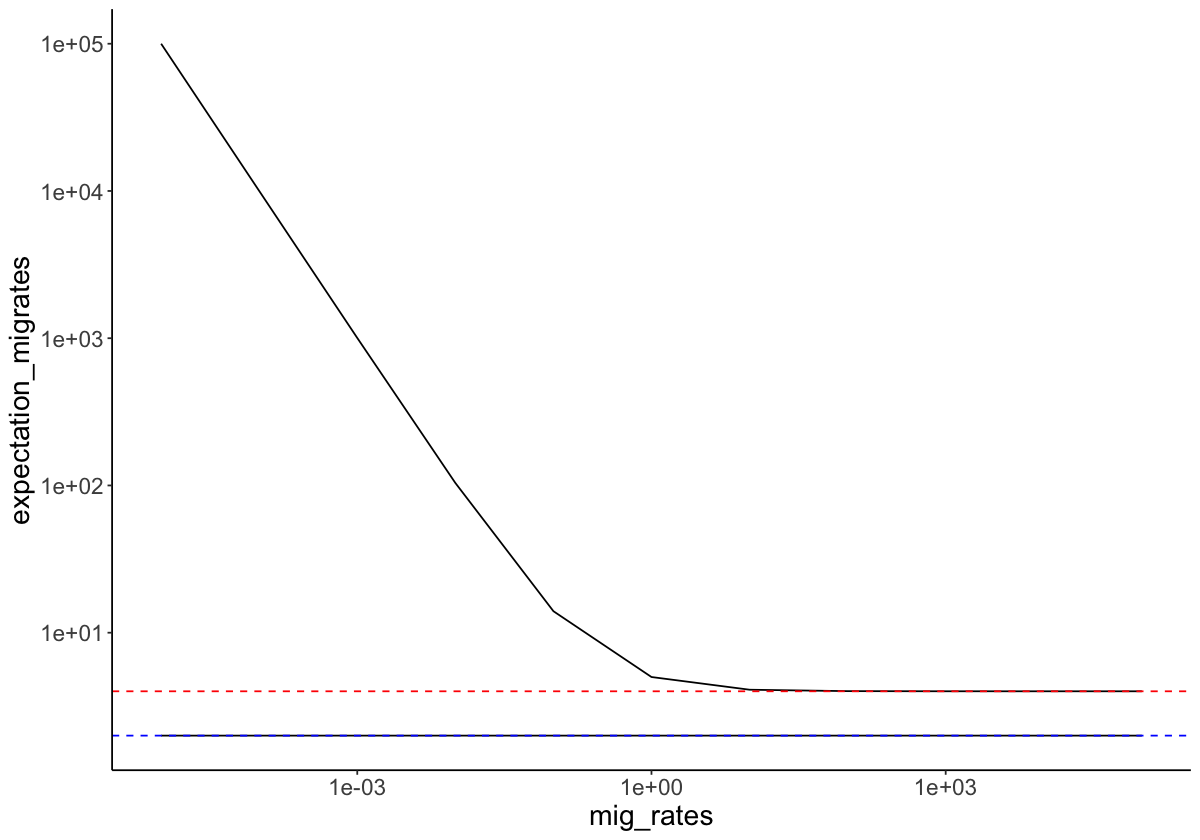

In [31]:
ggplot(data.frame(mig_rates=mig_rates, 
                         expectation_migrates=expectation_migrates),
             aes(x=mig_rates, expectation_migrates)) +
    geom_line() +
    geom_line(data=data.frame(mig_rates=mig_rates, 
                         variance_migrates=variance_migrates),
             aes(x=mig_rates, variance_migrates)) +
        scale_x_continuous(trans='log10') + 
        scale_y_continuous(trans='log10') +
        geom_hline(yintercept = 2, color='blue', linetype='dashed') +
        geom_hline(yintercept = 4, color='red', linetype='dashed') + despine

# Distribution of number of outgoing edes

In [32]:
s <- 6

In [33]:
graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 1)
print(vertices_length(graph))
si <- sign(graph_as_matrix(graph)$SIM)
diag(si) <- 0
outgoing_edge_counts <- rowSums(si)
# qplot(outgoing_edge_counts)

[1] 1044


Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


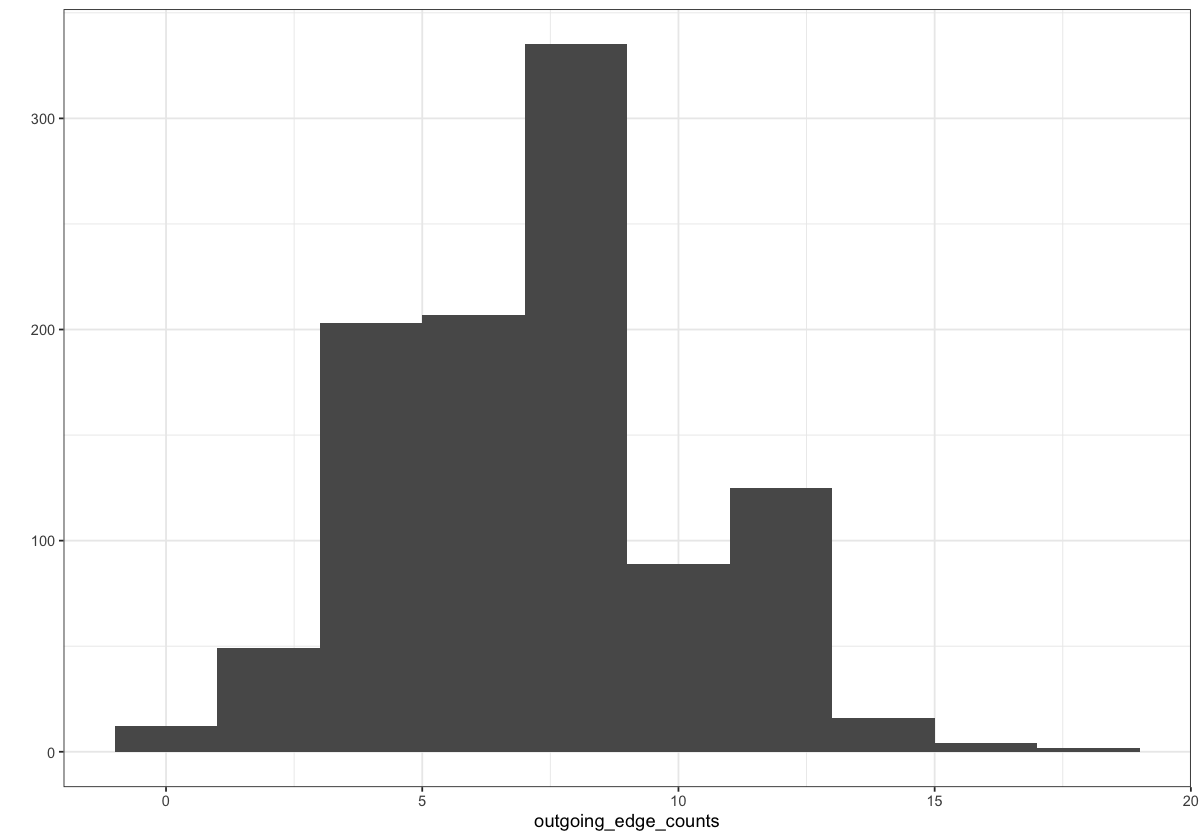

In [34]:
qplot(outgoing_edge_counts, bins=10)

# Two-locus SFS

Expected ARG branches with i and j tons at each locus

In [35]:
# %%R -o s
# s <- 4

No migration:

In [36]:
# %%R
# graph <- construct_twolocus_island_graph(s, 1, 1, 1, 1, 1)
# rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
# vertices_length(graph)

In [37]:
# %%R

# library(foreach)
# foreach (i=1:3) %do% {
#   sqrt(i)
# }

In [38]:
broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

two_locus_expectation <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    exp_mat <- matrix(nrow=s+1,ncol=s+1)
    for (i in 0:s) {
      for (j in 0:s) {
        exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
      }
    }
    return(exp_mat)
} 

In [39]:
exp_mat <- two_locus_expectation(s, 1, 1, 1)
exp_mat

0.0000000,1.11414254,0.83875209,0.66236776,0.56096603,0.49571161,1.3170671
1.1141425,2.06069441,0.10381944,0.07931653,0.05190836,0.04708094,0.1069803
0.8387521,0.10381944,0.76137927,0.08150143,0.06143870,0.03696461,0.1063918
0.6623678,0.07931653,0.08150143,0.38358502,0.05768776,0.04077732,0.1066635
0.5609660,0.05190836,0.06143870,0.05768776,0.21917256,0.04321406,0.1149075
0.4957116,0.04708094,0.03696461,0.04077732,0.04321406,0.14602283,0.1255997
1.3170671,0.10698025,0.10639182,0.10666349,0.11490751,0.12559967,0.0000000


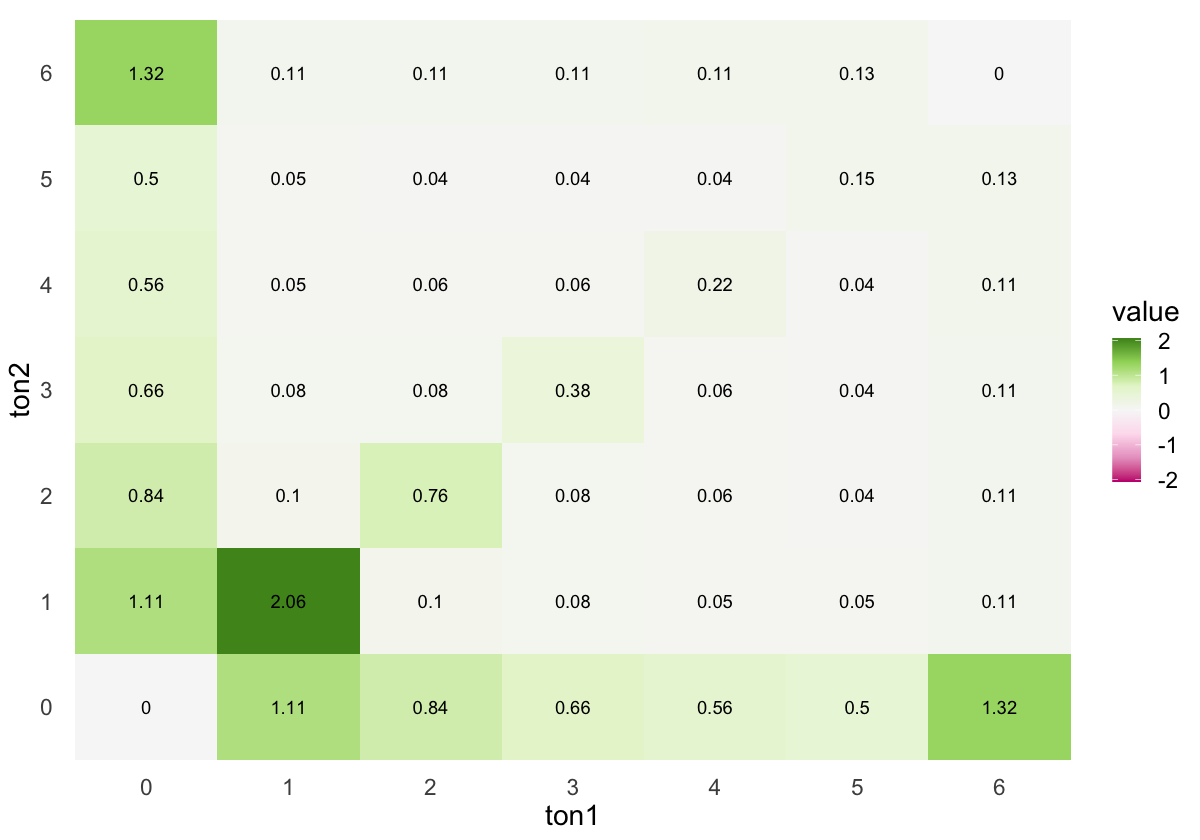

In [40]:
plot_exp_mat(exp_mat)

# Covriance between tons at locus one

In [41]:
broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

ton_covariance_within_locus <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(graph, locus1_rewards(i), locus1_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
}    

No migration and no recombination:

In [42]:
cov_mat_no_mig <- ton_covariance_within_locus(s, 1, 0, 0) 

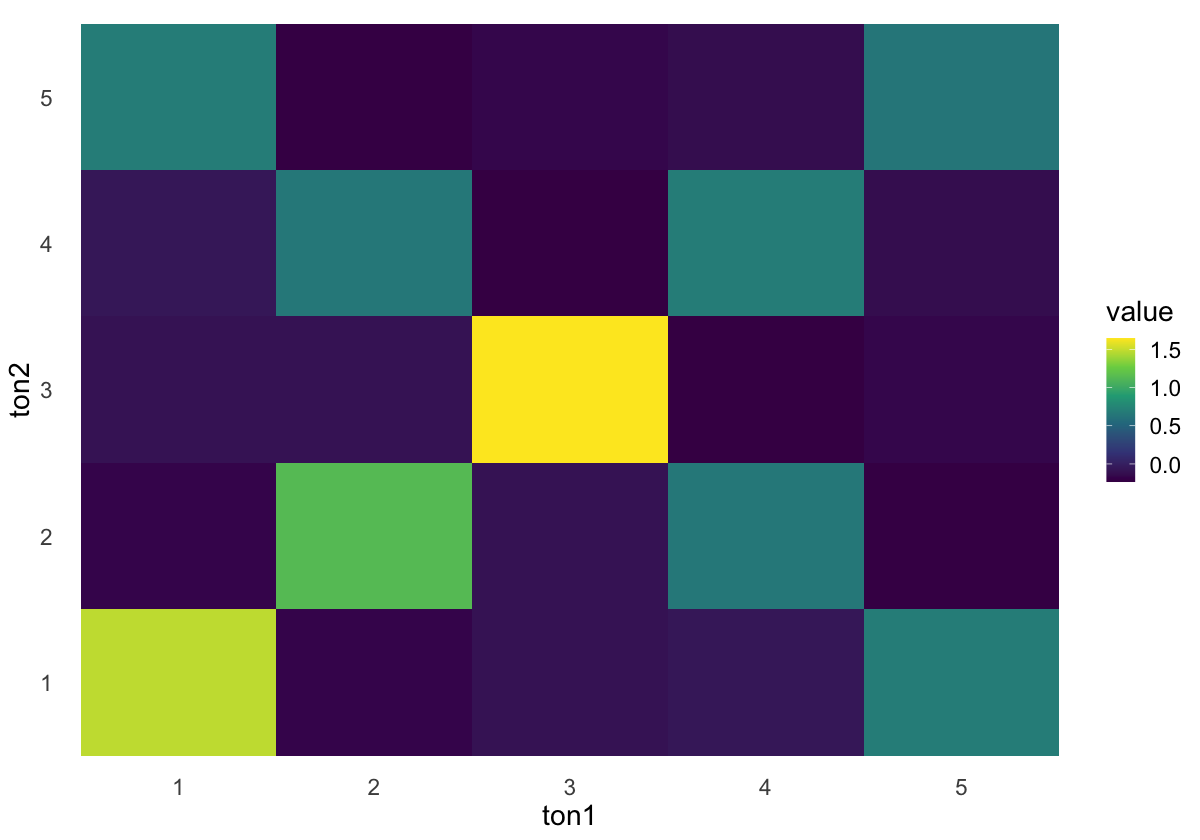

In [43]:
plot_cov_mat(cov_mat_no_mig)

# Covriance between tons between loci

In [44]:
broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

ton_covariance_between_loci <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }
    locus2_rewards <- function(j) {
        colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(graph, locus1_rewards(i), locus2_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
}    

No migration and no recombination:

In [45]:
cov_mat_no_rec_no_mig <- ton_covariance_between_loci(s, 1, 0, 0) 

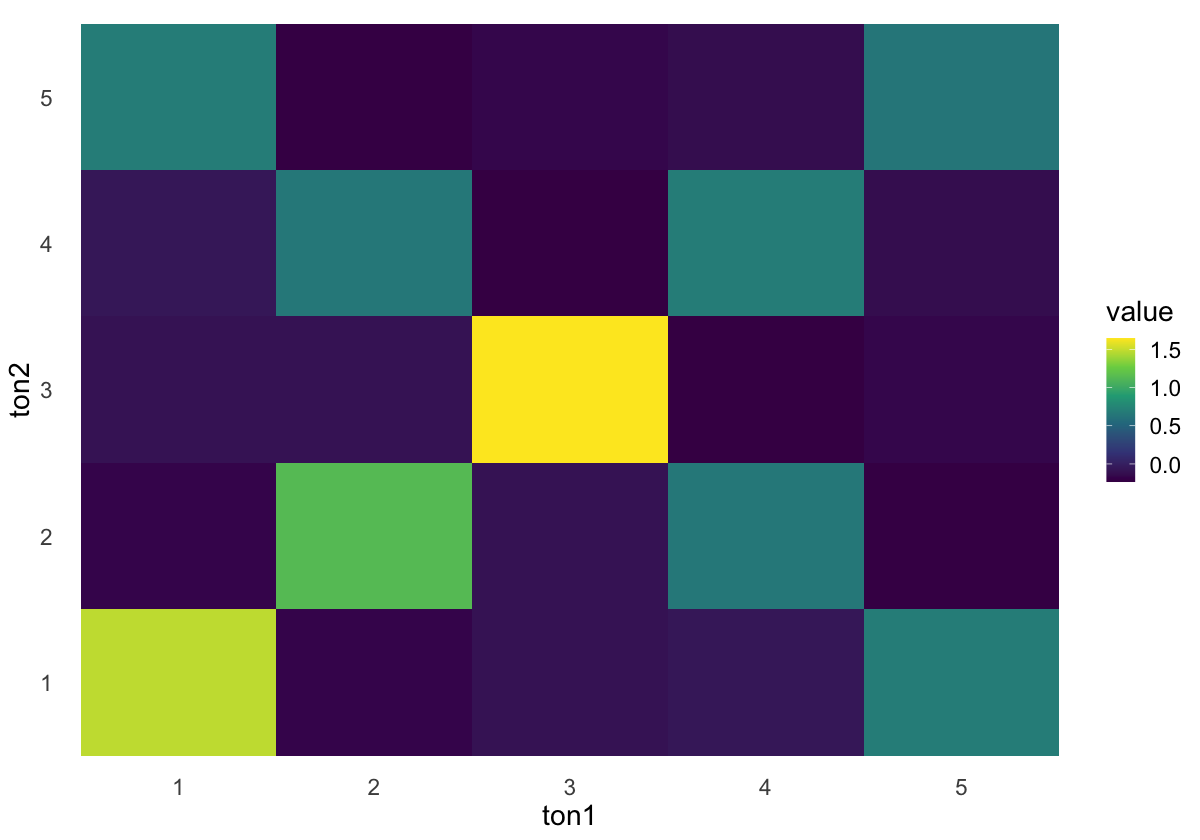

In [46]:
plot_cov_mat(cov_mat_no_rec_no_mig)

With recombination:

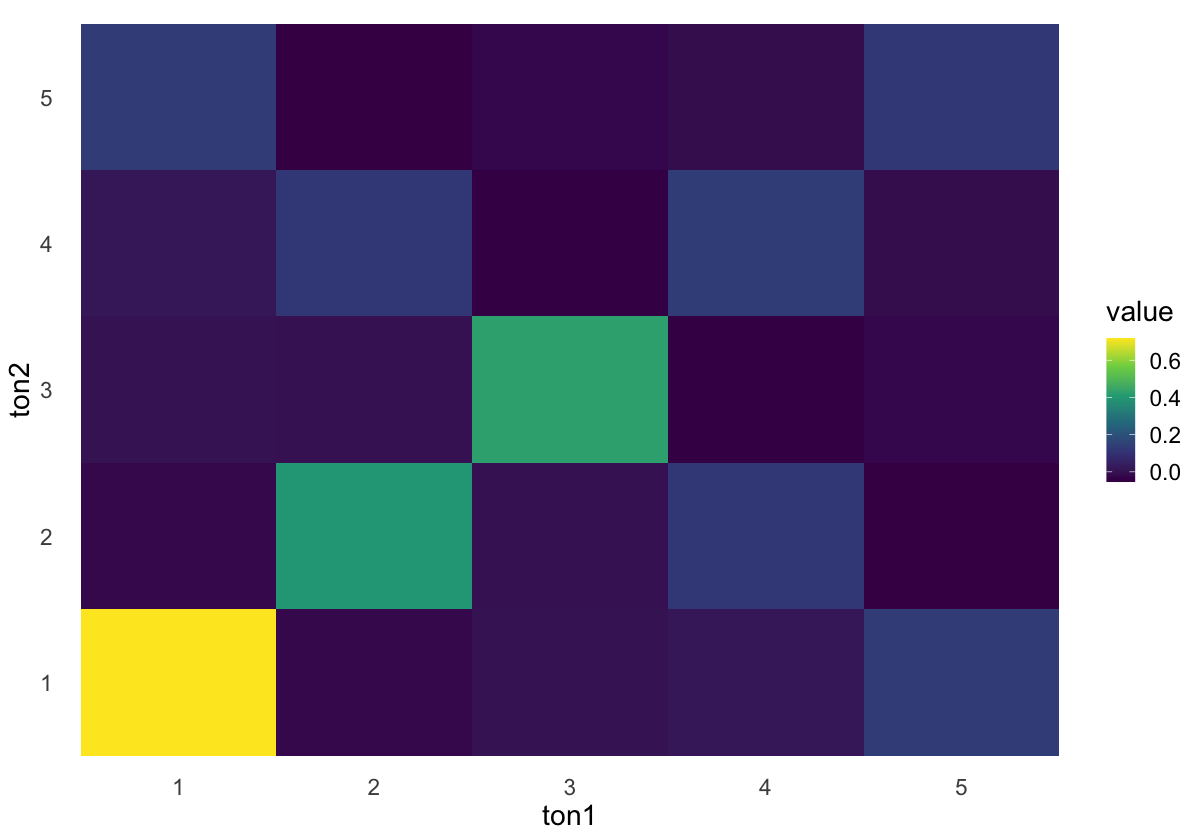

In [47]:
cov_mat_no_mig <- ton_covariance_between_loci(s, 1, 0, 1)
plot_cov_mat(cov_mat_no_mig)

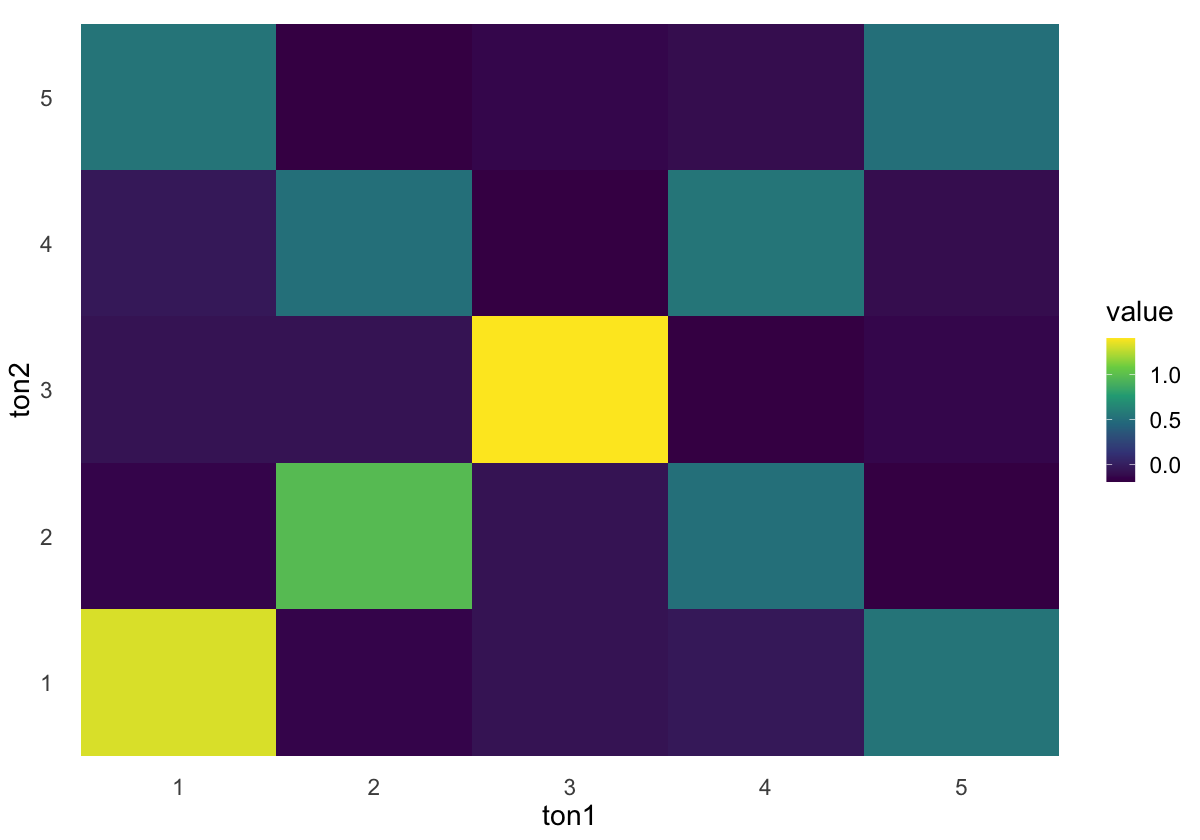

In [48]:
cov_mat_low_rec <- ton_covariance_between_loci(s, 1, 0, 0.1) 
plot_cov_mat(cov_mat_low_rec)

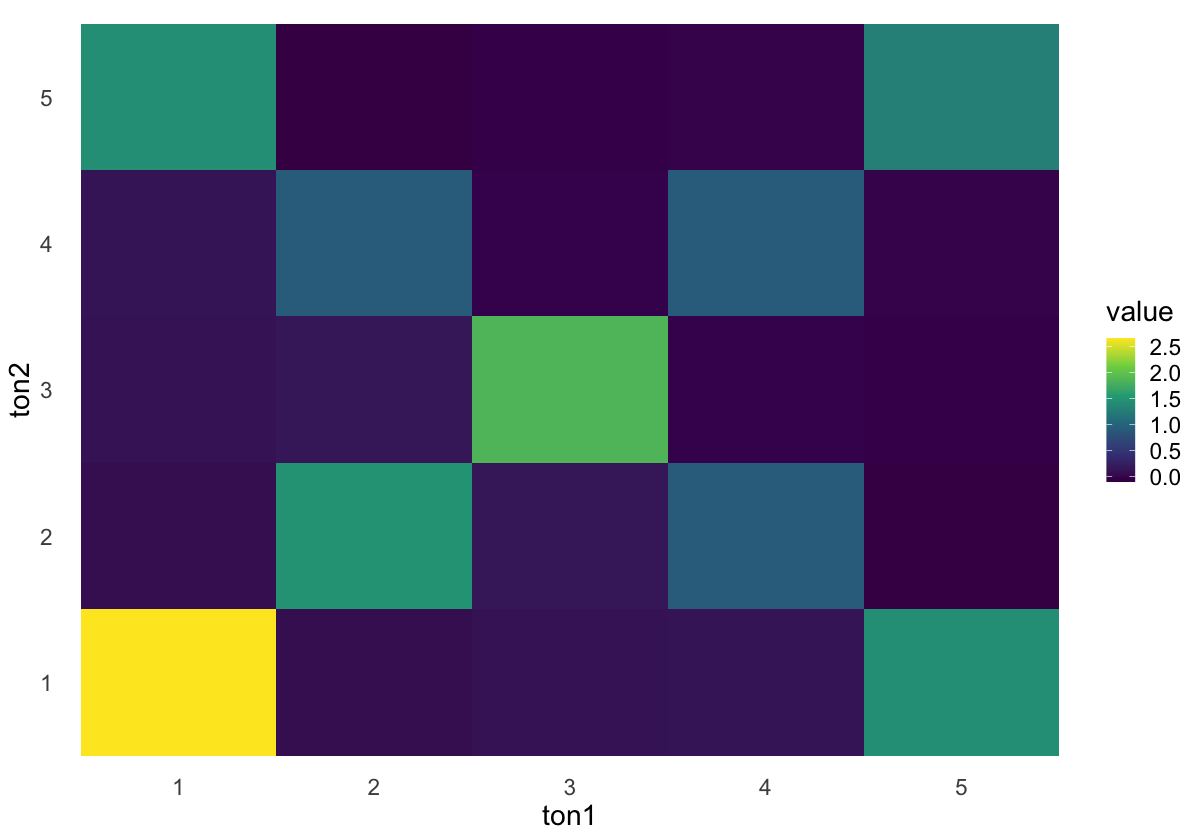

In [49]:
cov_mat_mig <- ton_covariance_between_loci(s, 1, 0.1, 1) 
plot_cov_mat(cov_mat_mig)

# Covariance of ARG branches in the two populations

Covariance of two-locus "ton" branch length (e.g. singletons at locus 1 and doubletons at locus 2) spent in each population.

In [50]:
graph <- construct_twolocus_island_graph(s, 1, 1, 1, 1, 1)
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

In [51]:
fun <- function(a, b) {
    mapply(function(i, j) covariance(graph, 
                                     rewards[props_to_index(s, i, j, 1),], 
                                     rewards[props_to_index(s, i, j, 2),]), 
           a, b)
}
cov_mat <- outer(1:(s-1), 1:(s-1), fun)

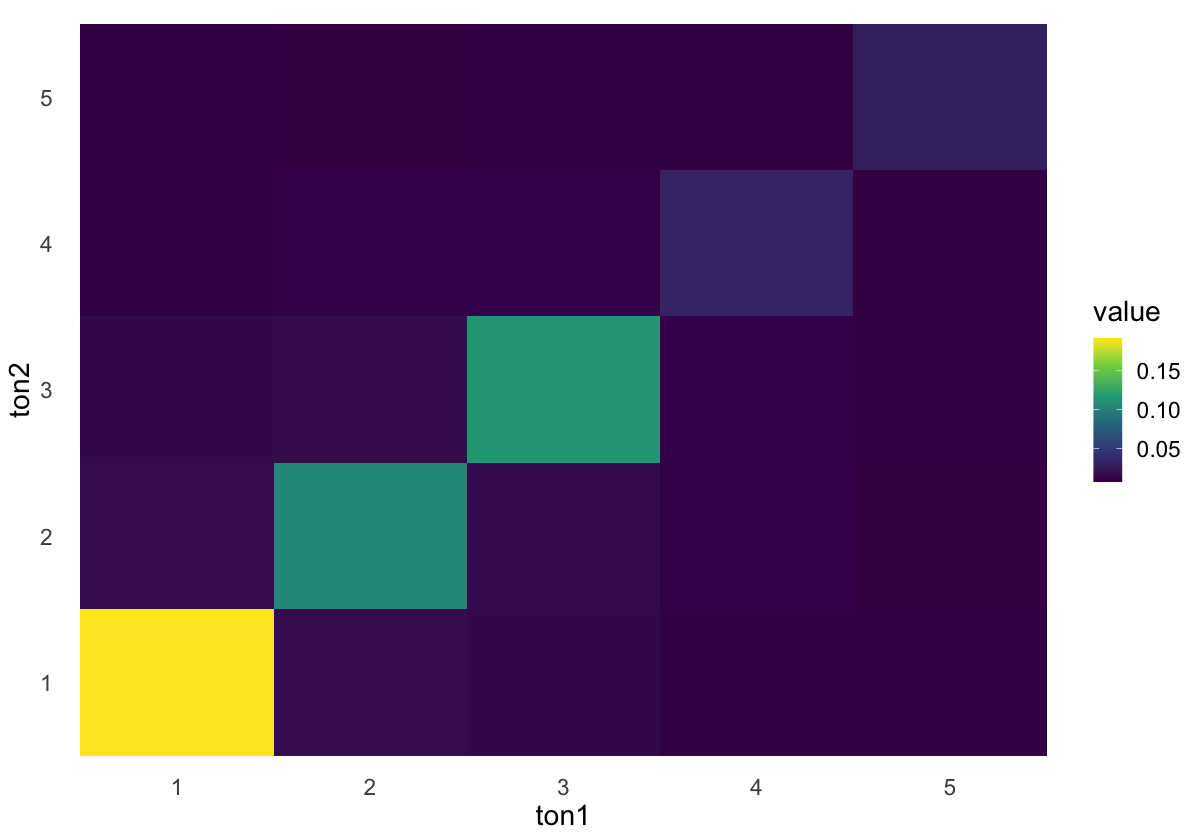

In [52]:
plot_cov_mat(cov_mat)

Shows that when there are hte same number of decendants at each locus (mostly becuase of no recombination) then the covariance is highest. Mostly for small tons where there are many lineages to back and forth between popoulations.

In [53]:
# %%R

# setClass("conf", slots=list(locus1="numeric", locus2="numeric", population="numeric"))

# obj <- new("conf", locus1=3, locus2=2, population=1)
# obj@population

# r_index_to_props <- function(s, i) {
#     #' returns the locus1, locus2, population
#     #' conformation of lineages represented by
#     #' state vector index i.
#     stopifnot(i > 0)
#     d <- s + 1 # dim
#     idx <- i - 1
#     p <- idx %/% d**2
#     stopifnot(i <= 2*d**2)
#     a <- (idx - p*d**2) %/% d
#     b <- (idx - p*d**2) %% d
#     return(new("conf", locus1=a, locus2=b, population=p+1))
# }
# r_props_to_index <- function(s, a, b, p) {
#     #' returns the state vector index representing
#     #' the locus1, locus2, population conformation.
#     d <- s + 1
#     i = (p-1)*d**2 + a*d + b + 1
#     return(i)
# }

# Inference

In [ ]:
s <- 5

expected_cov_mat <- ton_covariance_between_loci(s, 1, 0.5, 2)
# expected_cov_mat <- (expected_cov_mat - mean(expected_cov_mat)) / sd(expected_cov_mat)

expected_exp_mat <- two_locus_expectation(s, 1, 0.5, 2)
# expected_exp_mat <- (expected_exp_mat - mean(expected_exp_mat)) / sd(expected_exp_mat)


fit <- function(N, M) {
    observed_cov_mat <- ton_covariance_between_loci(s, N, M, 2)
    # observed_cov_mat <- (observed_cov_mat - mean(observed_cov_mat)) / sd(observed_cov_mat)
    
    observed_exp_mat <- two_locus_expectation(s, N, M, 2)
    # observed_exp_mat <- (observed_exp_mat - mean(observed_exp_mat)) / sd(observed_exp_mat)
    
    cov_fit <- abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat, na.rm=TRUE))
    exp_fit <- abs(sum((observed_exp_mat - expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
    return(exp_fit + cov_fit)
}

n <- seq(0.5, 1.5, 0.05)
m <- seq(0.1, 1.1, 0.05)
params <- expand.grid(n, m)
fit_mat <- matrix(mapply(fit, params$Var1, params$Var2), nrow=length(n),ncol=length(m))

In [83]:
rownames(fit_mat) <- n
colnames(fit_mat) <- m

In [78]:
df <- as.data.frame(fit_mat) #%>% gather()
df <- df %>% rownames_to_column('n') %>% gather('m', 'value', -c(n))
df$n <- as.numeric(df$n)
df$m <- as.numeric(df$m)

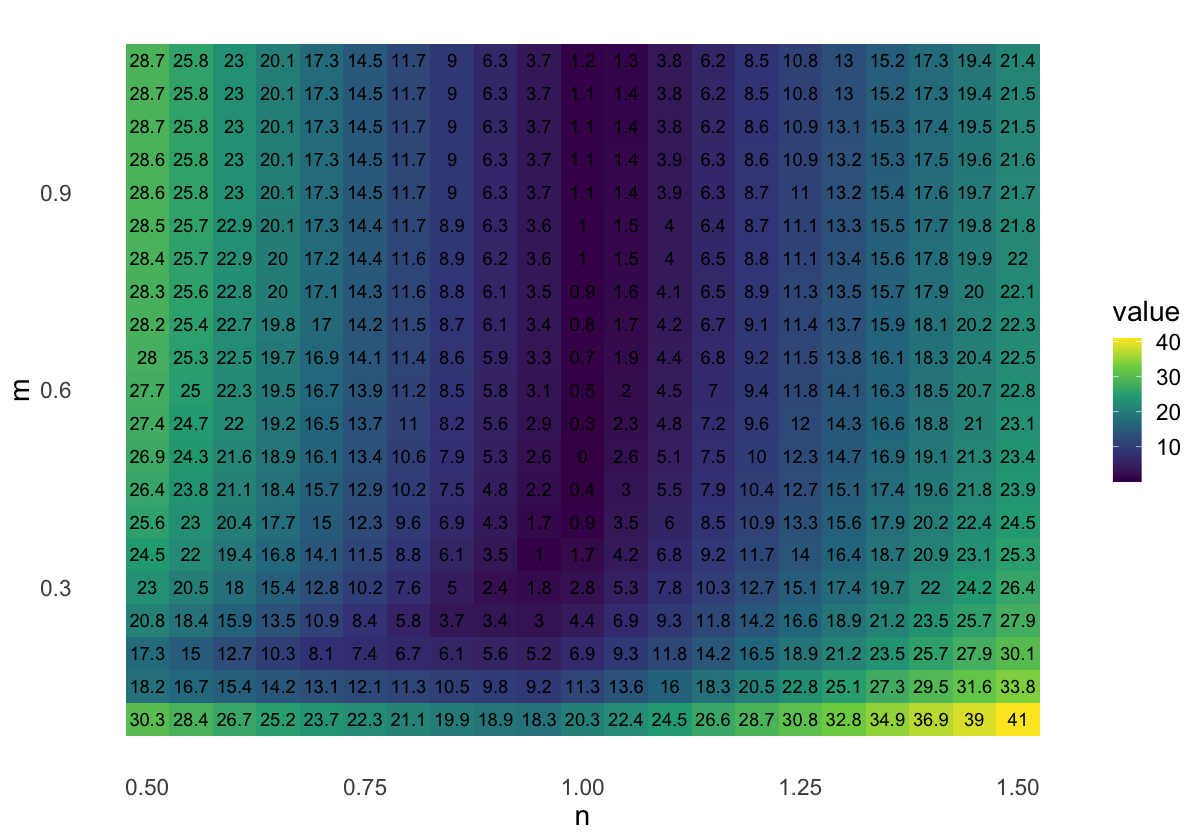

In [90]:
ggplot(df, aes(n, m)) +
    geom_tile(aes(fill = value)) + 
    geom_text(aes(label = round(value, 1))) +
        scale_fill_continuous(type = "viridis") + 
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              text=element_text(size=17))

## Multiprocessing

In [ ]:
library(parallel)

apply_grid <- function(fun, a, b) {
    named_params <- expand.grid(a, b)
    param_list <- split(named_params, seq(nrow(named_params)))    
    result_list <- mclapply(param_list, function(x) do.call(fit, as.list(as.vector(unlist(x)))), mc.cores=4L)
    fit_mat <- matrix(unlist(result_list), nrow=length(a),ncol=length(b))
    return(fit_mat)
}

s <- 4
expected_cov_mat <- ton_covariance_between_loci(s, 1, 0.5, 2)
expected_exp_mat <- two_locus_expectation(s, 1, 0.5, 2)


# fit <- function(N, M) {
#     observed_cov_mat <- ton_covariance_between_loci(s, N, M, 2)
#     return( abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat)) )
# }
n <- seq(0.5, 2.5, 0.05)
m <- seq(0.01, 2.01, 0.05)
fit_mat <- apply_grid(fit, n, m)

In [ ]:
fit_mat

In [ ]:
# plot_df = pd.DataFrame(fit_mat, columns=np.round(m, 2), index=np.round(n, 2))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# g = sns.heatmap(plot_df, cmap="viridis", ax=ax1)
# ax1.invert_yaxis()
# plot_df.where(plot_df <= 0, np.nan)
# g = sns.heatmap(np.log10(plot_df), cmap="viridis", ax=ax2)
# ax2.invert_yaxis()
# plt.savefig('fit2.pdf', bbox_inches='tight')

## Covariance betwen pop1/pop2 descendang configurations at each locus

In [ ]:
p1 <- 0:(s-1)
p2 <- 0:(s-1)
l1 <- expand.grid(p1=p1, p2=p2)
l2 <- expand.grid(p1=p1, p2=p2)

In [ ]:
df <- do.call(cbind.data.frame,Map(expand.grid,l1=l1,l2=l2))
df <- df[order(df$p1.l1, df$p2.l1, df$p1.l2, df$p2.l2),]

In [ ]:
fun <- function(row) {
    covariance(graph, 
                                     rewards[props_to_index(s, row[1], row[2], 1),], 
                                     rewards[props_to_index(s, row[3], row[4], 2),])
}

In [ ]:
m <- matrix(apply(df, 1, fun), c(s**2, s**2))
colnames(m) <- apply(l1, 1, paste, collapse=",")
rownames(m) <- apply(l2, 1, paste, collapse=",")
m

In [ ]:
plot_cov_mat <- function(cov_mat) {
   
    df <- as.data.frame(cov_mat)
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
#        scale_y_discrete(labels= seq(1, nrow(cov_mat))) + 
        scale_fill_continuous(type = "viridis") + 
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

}
plot_cov_mat(m)

## Time-inhomgeneous coalescent

# TODO: 

Implement something like `cdf_timeinhom` from `coalescent-R.ipynb`